# Notes
* Sometimes the WTK/NSRDB data download in `linerating.get_weather_h5py()` can hang; if it does, wait a few minutes and try again
* Make sure to use the `dlr` conda environment when running this notebook

# Imports

In [1]:
#%% Imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
import folium
import fiona
## Local
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from dlr import helpers
from dlr import linerating
from dlr import paths
from dlr import physics
from dlr import plots
## Plot formatting
plots.plotparams()
pyproj.network.set_network_enabled(False)
pd.options.display.max_columns = 200
pd.options.display.max_rows = 30

# Pick lines to analyze

### Get a sample of HIFLD lines from a given state
* Need to download the HIFLD shapefile from https://hifld-geoplatform.hub.arcgis.com/datasets/geoplatform::transmission-lines first

In [2]:
### Restrict to high-voltage (≥115 kV) lines of ≤50-mile length
dfhifld = helpers.get_hifld(min_kv=115, max_miles=50)

In [3]:
#%% Get some HIFLD lines from a given state (need to download the HIFLD data first)
dfstates =  helpers.get_reeds_zones()['st']
state = 'CO'
statebounds = dfstates.loc[[state]].bounds.squeeze()
dflines = dfhifld.loc[
    (dfhifld.length_miles >= 5)
    & (dfhifld.rep_voltage == 230)
    & (dfhifld.bounds.maxy <= statebounds.maxy)
    & (dfhifld.bounds.maxx <= statebounds.maxx)
    & (dfhifld.bounds.minx >= statebounds.minx)
    & (dfhifld.bounds.miny >= statebounds.miny)
].sample(4, random_state=1)

### OR pick some specific HIFLD lines from a map

In [ ]:
rep_voltages = [115, 230, 345, 500, 765]
color_voltage = dict(zip(
    rep_voltages,
    ['red', 'orange', 'green', 'blue', 'purple'],
))
lw_voltage = dict(zip(
    rep_voltages,
    [1, 2, 3, 4, 5],
))
tiles = "CartoDB positron"
m = dfstates.explore(
    color='none', tiles=tiles, name='State',
    style_kwds={'color':'black', 'weight':0.2},
)
## Pick from a given voltage range
keep_voltages = [230, 345, 500, 765]
for rep_voltage in keep_voltages:
    (
        dfhifld.loc[dfhifld.rep_voltage==rep_voltage]
        .drop(columns=['SOURCEDATE','VAL_DATE'], errors='ignore')
        .round({'length_miles':1})
    ).explore(
        m=m, tooltip=['ID','VOLTAGE','length_miles'],
        style_kwds={'color':color_voltage[rep_voltage], 'weight':lw_voltage[rep_voltage]},
        name=rep_voltage
    )
folium.LayerControl().add_to(m)
m

The interactive map above won't render on github, but if run locally you can interact with it like this:
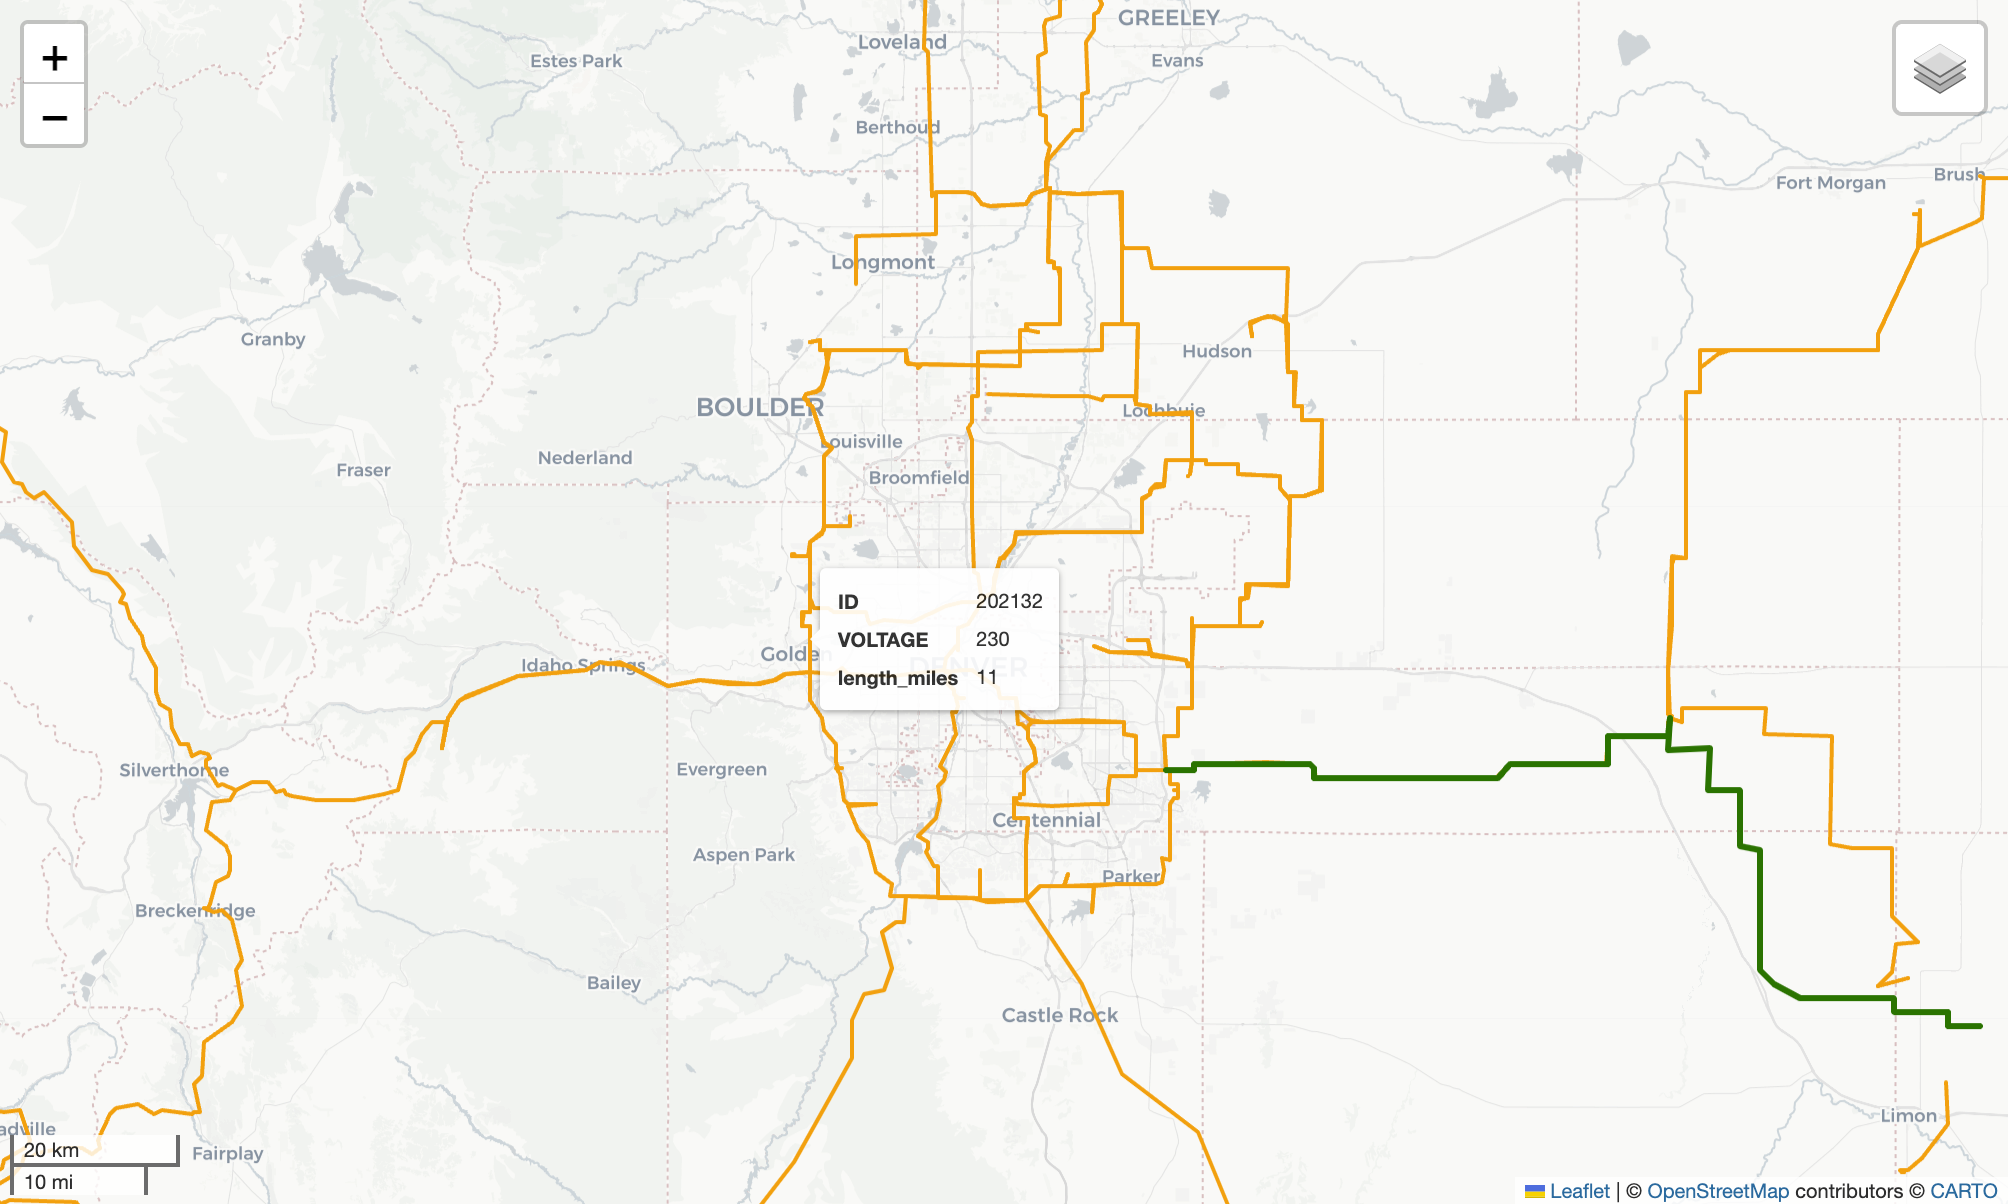

In [ ]:
keep_ids = [202132]
dflines = dfhifld.loc[keep_ids].copy()

### OR get user-defined line routes
The example below uses a .kml file exported from Google Earth

In [ ]:
fiona.supported_drivers['KML'] = 'rw'
dflines = (
    gpd.read_file(os.path.join(paths.data,'test_lines.kml'), driver='KML')
    .rename(columns={'Name':'ID'})
    .to_crs('ESRI:102008')
    .assign(VOLTAGE=230)
)
dflines = helpers.lookup_diameter_resistance(dflines).set_index('ID')
## Get SLR for comparison
dflines['SLR'] = physics.ampacity(
    diameter_conductor=dflines.diameter,
    resistance_conductor=dflines.resistance,
)

## Take a look at the lines to be analyzed
Here we use the first of the three options above, sampling a few lines from Colorado

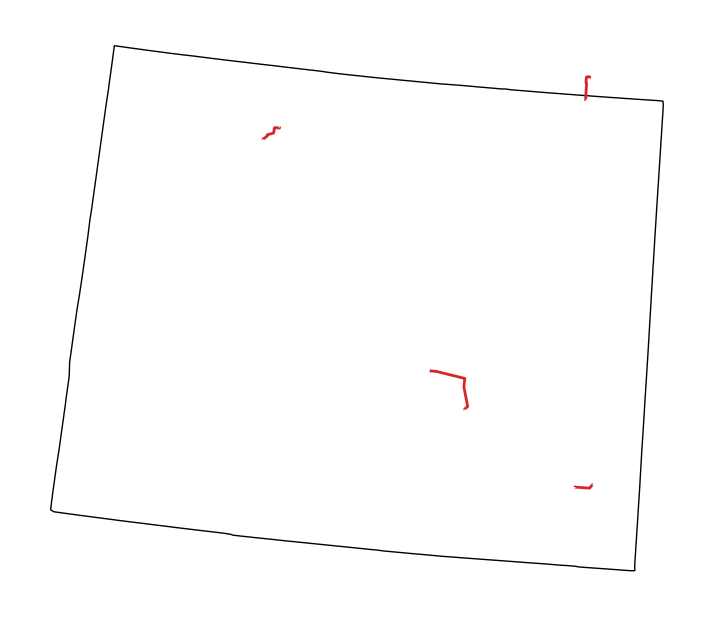

In [4]:
### Take a look
dfstate = helpers.get_reeds_zones()['st'].loc[[state]]
plt.close()
f, ax = plt.subplots()
dfstate.plot(ax=ax, facecolor='none', edgecolor='k', lw=0.5)
dflines.plot(ax=ax, color='C3', lw=1)
ax.axis('off')
plt.show()

# Get weather grid cells

In [5]:
#%% Get WTK and NSRDB cells
meta = helpers.get_grids()

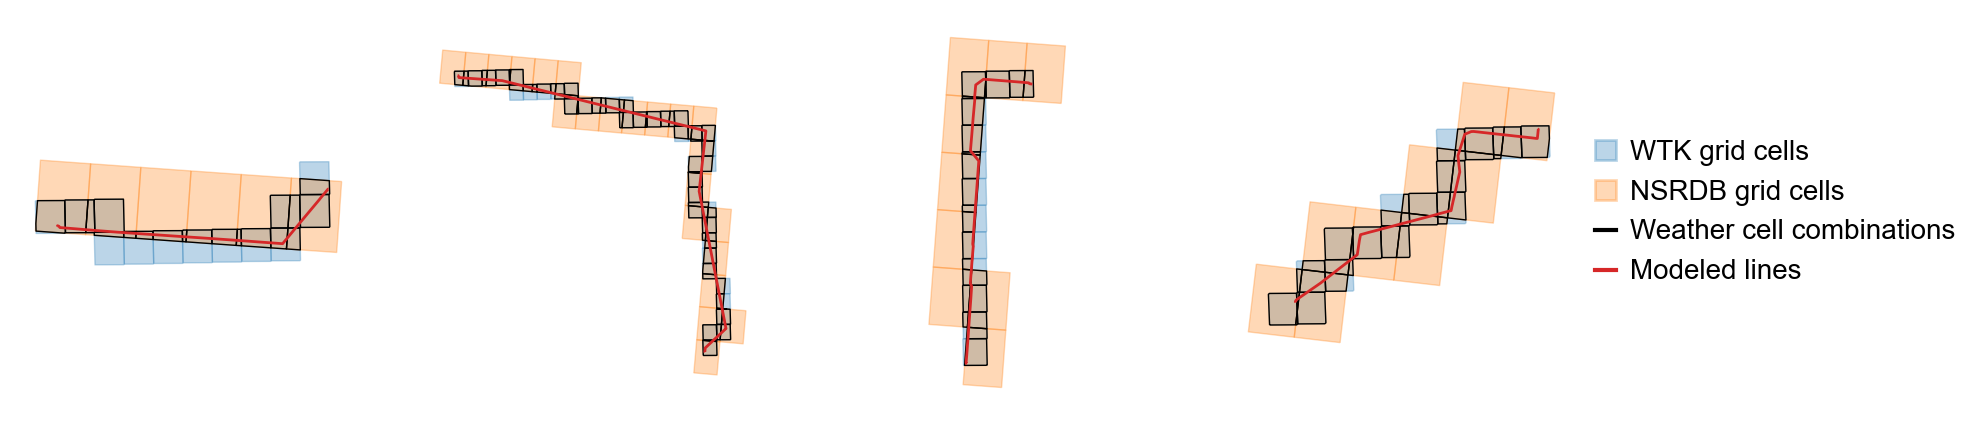

In [6]:
#%% Take a look
colors = {'wtk':'C0', 'nsrdb':'C1'}
alpha = 0.3
ncols = min(len(dflines), 5)
plt.close()
f,ax = plt.subplots(1,ncols,figsize=(2.5*ncols, 2.5))
for col, (iline, line) in enumerate(dflines.iterrows()):
    keep_cells = linerating.get_cells(line=line, meta=meta, buffer_km=10)
    cell_combinations = linerating.get_cell_overlaps(keep_cells=keep_cells)
    for data, c in colors.items():
        keep_cells[data].plot(ax=ax[col], alpha=alpha, facecolor=c, edgecolor=c, lw=0.5)
    cell_combinations.plot(ax=ax[col], facecolor='none', edgecolor='k', lw=0.5)
    dflines.iloc[[col]].plot(ax=ax[col], color='C3', lw=1.0)

handles = [
    mpl.patches.Patch(
        facecolor=colors[data], edgecolor=colors[data], alpha=alpha,
        label=f'{data.upper()} grid cells',
    ) for data in colors
] + [
    mpl.lines.Line2D([], [], color='k', label='Weather cell combinations'),
    mpl.lines.Line2D([], [], color='C3', label='Modeled lines'),
]
ax[-1].legend(
    handles=handles, loc='center left', frameon=False, bbox_to_anchor=(1,0.5),
    handlelength=0.75, handletextpad=0.5,
)

for col in range(ncols):
    ax[col].axis('off')
plt.show()

# Calculate ratings

In [7]:
## Output container
years = range(2007,2014)
ratings = {}

## Full dynamic line rating, including irradiance and wind speed/direction

In [8]:
method = 'DLR'
ratings[method] = {}
for iline, line in dflines.iterrows():
    ### Get grid cells
    keep_cells = linerating.get_cells(line=line, meta=meta, buffer_km=10)
    cell_combinations = linerating.get_cell_overlaps(keep_cells=keep_cells)

    ### Get segment angles from North
    line_segments = linerating.get_segment_azimuths(
        line=line, cell_combinations=cell_combinations)

    ### Get weather data
    dfweather = linerating.get_weather_h5py(
        line=line,
        meta=meta,
        weatherlist=['temperature','windspeed','winddirection','pressure','ghi'],
        years=years,
        verbose=1,
    )

    ### Calculate ratings for all segments
    segment_ampacity = {}
    for segment, (i_wtk, i_nsrdb, azimuth) in line_segments.iterrows():
        segment_ampacity[segment] = physics.ampacity(
            windspeed=dfweather['windspeed'][i_wtk],
            wind_conductor_angle=(dfweather['winddirection'][i_wtk] - azimuth),
            temp_ambient_air=(dfweather['temperature'][i_wtk] + physics.C2K),
            pressure=dfweather['pressure'][i_wtk],
            solar_ghi=dfweather['ghi'][i_nsrdb],
            diameter_conductor=line.diameter,
            resistance_conductor=line.resistance,
        )
    segment_ampacity = pd.concat(segment_ampacity, axis=1)
    ### Line rating is the minimum across all segments
    ratings[method][line.name] = segment_ampacity.min(axis=1)

201382: 100%|██████████| 35/35 [01:42<00:00,  2.92s/it]


## Clear-sky-irradiance adjusted ratings: No wind speed or direction

In [9]:
method = 'CLR'
defaults = {'windspeed': 0, 'wind_conductor_angle': 90}
ratings[method] = {}
for iline, line in dflines.iterrows():
    ### Get grid cells
    keep_cells = linerating.get_cells(line=line, meta=meta, buffer_km=10)
    cell_combinations = linerating.get_cell_overlaps(keep_cells=keep_cells)

    ### Get weather data
    dfweather = linerating.get_weather_h5py(
        line=line,
        meta=meta,
        weatherlist=['temperature','pressure','clearsky_ghi'],
        years=years,
        verbose=1,
    )

    ### Because we're not using wind direction we only need cell combinations, not segments
    cell_ampacity = {}
    for (i_wtk, i_nsrdb) in cell_combinations.index:
        cell_ampacity[(i_wtk, i_nsrdb)] = physics.ampacity(
            windspeed=defaults['windspeed'],
            wind_conductor_angle=defaults['wind_conductor_angle'],
            temp_ambient_air=(dfweather['temperature'][i_wtk] + physics.C2K),
            pressure=dfweather['pressure'][i_wtk],
            solar_ghi=dfweather['clearsky_ghi'][i_nsrdb],
            diameter_conductor=line.diameter,
            resistance_conductor=line.resistance,
        )
    cell_ampacity = pd.concat(cell_ampacity, axis=1)
    ratings[method][line.name] = cell_ampacity.min(axis=1)

201382: 100%|██████████| 21/21 [01:07<00:00,  3.20s/it]


## Ambient-temperature-adjusted ratings

In [10]:
method = 'ALR'
defaults = {'ghi':1000, 'windspeed': 0, 'wind_conductor_angle': 90}
ratings[method] = {}
for iline, line in dflines.iterrows():
    ### Get grid cells
    keep_cells = linerating.get_cells(line=line, meta=meta, buffer_km=10)
    cell_combinations = linerating.get_cell_overlaps(keep_cells=keep_cells)

    ### Get weather data
    dfweather = linerating.get_weather_h5py(
        line=line,
        meta=meta,
        weatherlist=['temperature'],
        years=years,
        verbose=1,
    )

    ### Because we're not using wind direction we only need cell combinations, not segments
    cell_ampacity = {}
    for (i_wtk, i_nsrdb) in cell_combinations.index:
        cell_ampacity[(i_wtk, i_nsrdb)] = physics.ampacity(
            windspeed=defaults['windspeed'],
            wind_conductor_angle=defaults['wind_conductor_angle'],
            temp_ambient_air=(dfweather['temperature'][i_wtk] + physics.C2K),
            solar_ghi=defaults['ghi'],
            diameter_conductor=line.diameter,
            resistance_conductor=line.resistance,
        )
    cell_ampacity = pd.concat(cell_ampacity, axis=1)
    ratings[method][line.name] = cell_ampacity.min(axis=1)

201382: 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]


# Plot ratings

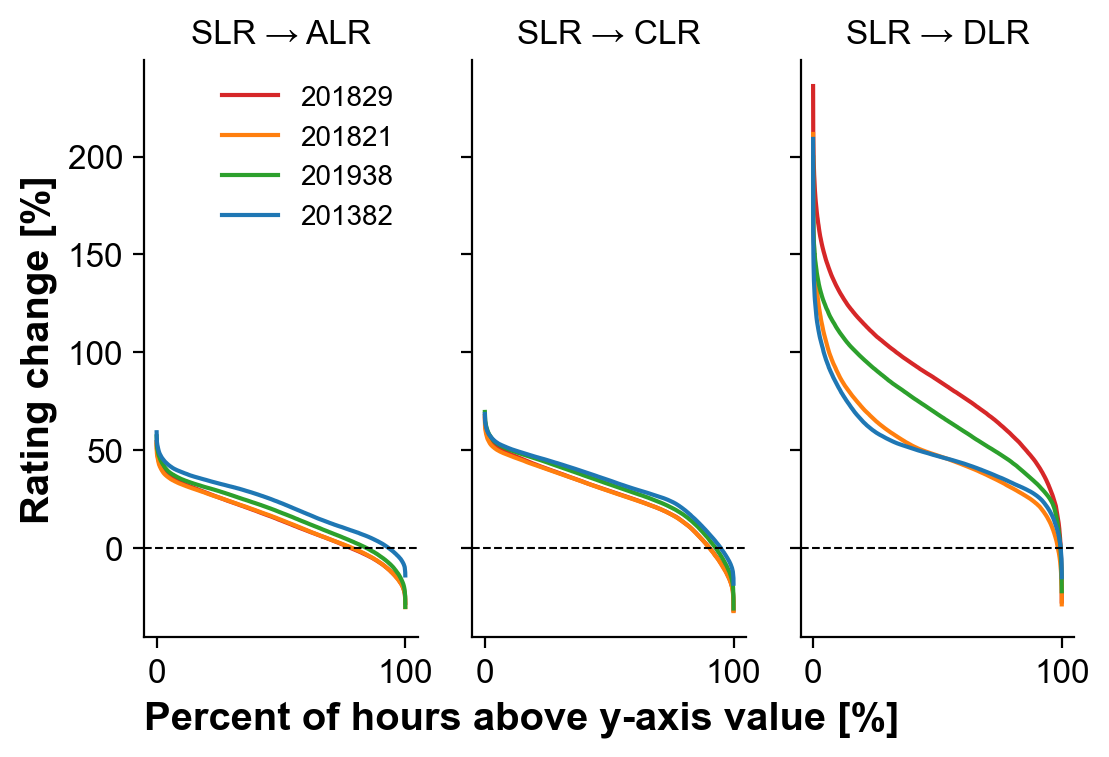

In [11]:
### Distribution of ratings
methods = ['ALR','CLR','DLR']
colors = plots.rainbowmapper(dflines.index)
ncols = len(methods)
plt.close()
f, ax = plt.subplots(1, ncols, figsize=(2*ncols, 3.75), sharex=True, sharey=True)
for col, method in enumerate(methods):
    df = pd.concat(ratings[method], axis=1)
    for line in colors:
        ax[col].plot(
            np.linspace(0,100,len(df)),
            (df[line].sort_values(ascending=False) / dflines.loc[line,'SLR'] - 1) * 100,
            c=colors[line], label=line,
        )
    ax[col].axhline(0, c='k', ls='--', lw=0.75)
    ax[col].set_title(f"SLR → {method}")
    if col == 0:
        ax[col].legend(loc='upper right', frameon=False)
ax[0].set_ylabel('Rating change [%]')
ax[0].set_xlabel('Percent of hours above y-axis value [%]', x=0, ha='left')
plots.despine(ax)
plt.show()